In [13]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 5.96MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 246kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████| 1.65M/1.65M [00:07<00:00, 225kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/5, Loss: 0.041817
Epoch 2/5, Loss: 0.039036
Epoch 3/5, Loss: 0.035660
Epoch 4/5, Loss: 0.031656
Epoch 5/5, Loss: 0.033188


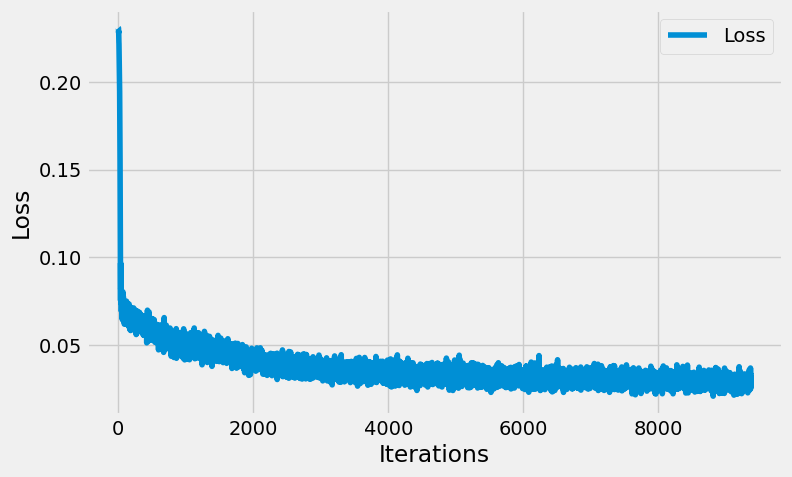

In [5]:
epochs = 5
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 28 * 28).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
loader2 = torch.utils.data.DataLoader(dataset=dataset, batch_size=300, shuffle=True)

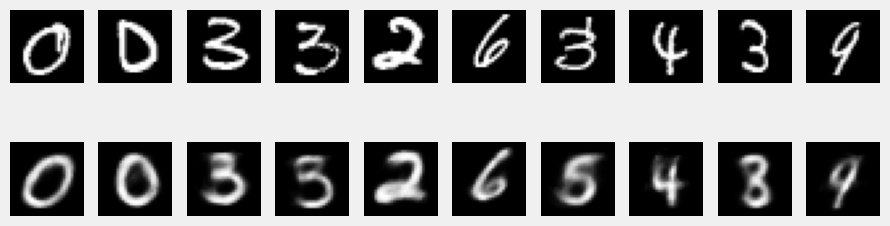

In [42]:
model.eval()
dataiter = iter(loader2)
images, _ = next(dataiter)

images = images.view(-1, 28 * 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

In [44]:
output_file = 'autoencoder_features_mnist.npy'
np.save(output_file, model.encoder(images).cpu().detach().numpy())

In [49]:
output_file = 'autoencoder_images_mnist.npy'
np.save(output_file,images.cpu().detach().numpy().reshape(len(images),28, 28))